PyTorch
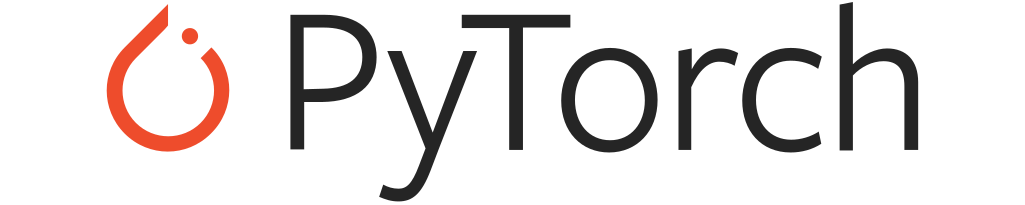

# Tensores
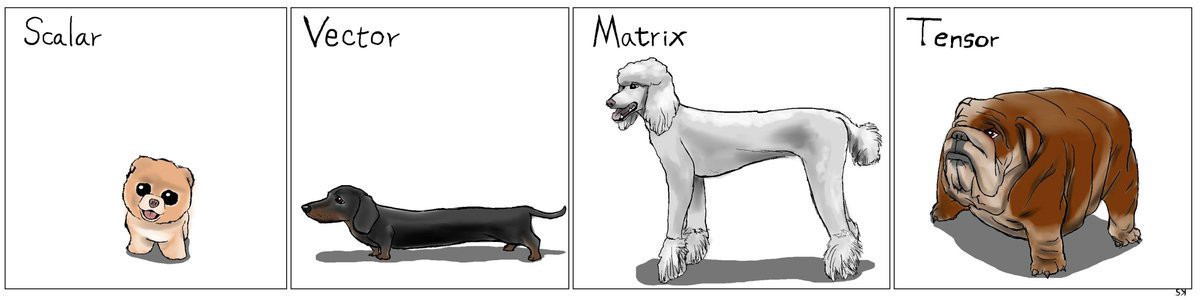

Los tensores son arrays multidimensionales, estos pueden ser asignados en la CPU ó GPU para acelerar las operaciones.

In [ ]:
import torch

In [ ]:
# Iniciando con FloatTensors
ten_1 = torch.tensor(2)
ten_2 = torch.tensor(5)

In [ ]:
print(ten_1 + ten_2)

tensor(7)


In [ ]:
print(ten_1 - ten_2)

tensor(-3)


In [ ]:
print(ten_1 * ten_2)

tensor(10)


In [ ]:
print(ten_1 / ten_2)

tensor(0.4000)


## Matrices en tensores

In [ ]:
tensor_rand = torch.tensor([[1,2],[3,4]])
print(tensor_rand)

tensor([[1, 2],
        [3, 4]])


In [ ]:
tensor_ones = torch.ones((3,3))
print(tensor_ones)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [ ]:
tensor_rand = torch.rand((3,3))
print(tensor_rand)

tensor([[0.1498, 0.7842, 0.9420],
        [0.9485, 0.7829, 0.3750],
        [0.8276, 0.8167, 0.8908]])


# GPU
Si queremos "pasar" a la GPU podemos hacerlo con:
<br>
* cuda()
* to('cuda')

Si queremos "pasar" a la CPU podemos hacerlo con:
<br>
* cpu()
* to('cpu')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

¿Qué tan veloz es?

In [ ]:
lis_1 = torch.randn(9000, 9000)
lis_2 = torch.randn(9000, 9000)

In [ ]:
%time calc = lis_1 * lis_2

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 137 ms


In [ ]:
lis_1 = torch.randn(9000, 9000).cuda()
lis_2 = torch.randn(9000, 9000).cuda()

In [ ]:
%time calc = lis_1 * lis_2

CPU times: user 486 µs, sys: 1.98 ms, total: 2.47 ms
Wall time: 2.48 ms


### Pasando tensores a la GPU

In [ ]:
device = torch.device("cuda")

In [ ]:
x = torch.randn(100)

In [ ]:
x = x.cuda()

In [ ]:
x = x.to(device)

In [ ]:
x = x.to("cuda")

# ANN con PyTorch
Creditos: [Documentación PyTorch](https://pytorch.org/tutorials/) 

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

En torchvision se tienen datasets para tareas de visión, como CIFAR, COCO, etc.

## FashionMNIST
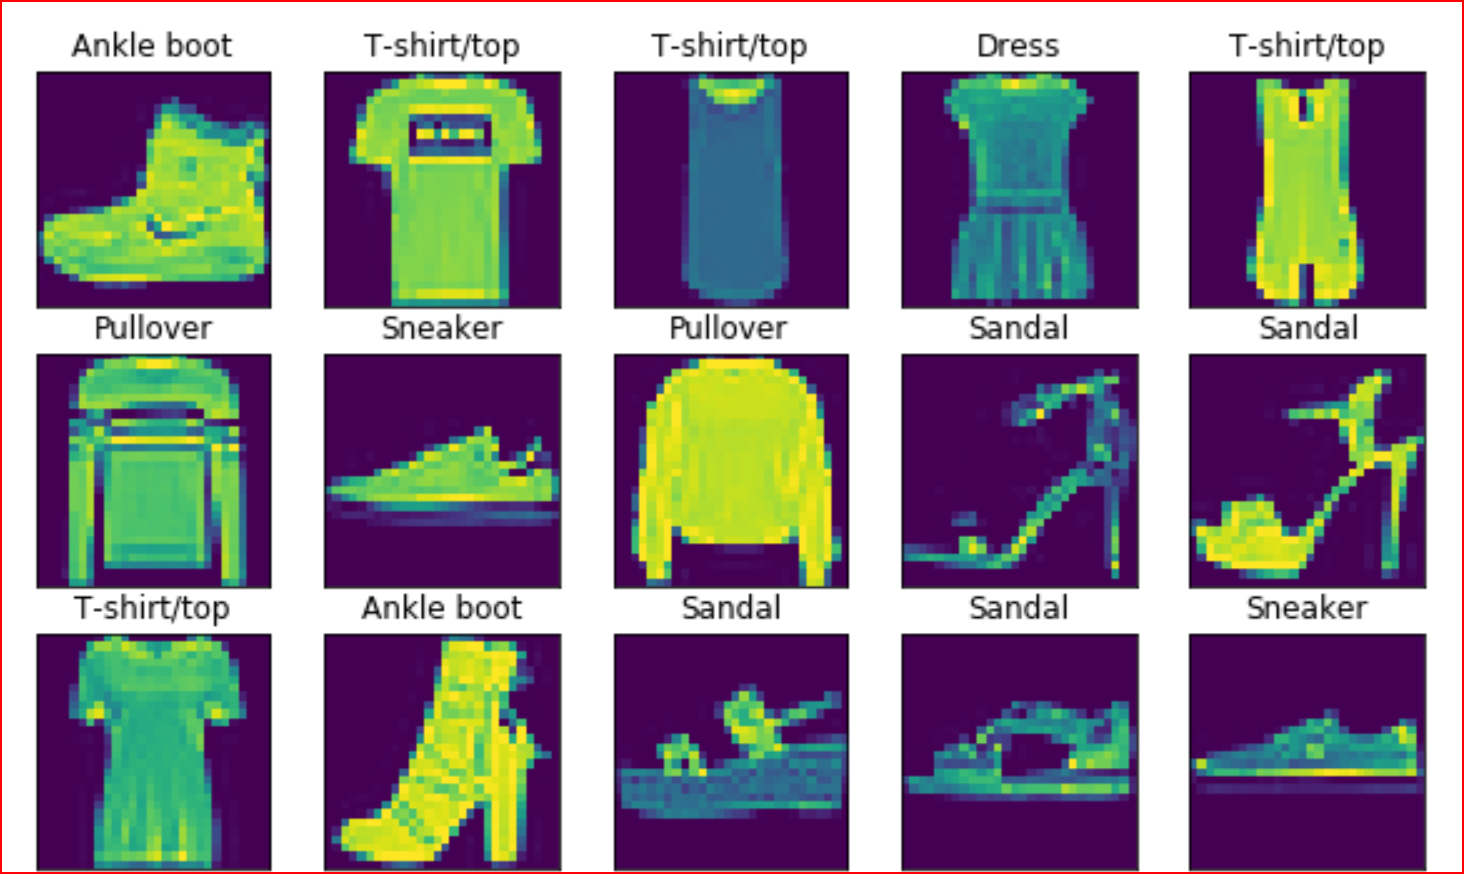

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Le pasamos los datos a los DataLoader, los cuales le dan la cualidad de volverle iterable ademas de poder ser procesado por lotes, muestreo, barajado, etc.<br>
Al poner 64 al batch_size, le estamos diciendo que el dataloader devolvera 64 datos (features, labels).

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Vemos si la GPU está disponible para usarla despues.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# Armando la red neuronal

Creamos una clase para definir la red neuronal, esta clase hereda de nn.Module.
<br>
Se definen las capas en __init__ y tambien especificamos como pasaran los datos en la ANN.
<br>

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:

            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.302073  [    0/60000]
loss: 2.290458  [ 6400/60000]
loss: 2.270083  [12800/60000]
loss: 2.265423  [19200/60000]
loss: 2.255364  [25600/60000]
loss: 2.216591  [32000/60000]
loss: 2.225388  [38400/60000]
loss: 2.186438  [44800/60000]
loss: 2.180256  [51200/60000]
loss: 2.157444  [57600/60000]
Test Error: 
 Accuracy: 51.4%, Avg loss: 2.148379 

Epoch 2
-------------------------------
loss: 2.157975  [    0/60000]
loss: 2.148098  [ 6400/60000]
loss: 2.085933  [12800/60000]
loss: 2.103893  [19200/60000]
loss: 2.057516  [25600/60000]
loss: 1.993039  [32000/60000]
loss: 2.024239  [38400/60000]
loss: 1.937191  [44800/60000]
loss: 1.942553  [51200/60000]
loss: 1.885357  [57600/60000]
Test Error: 
 Accuracy: 59.7%, Avg loss: 1.869799 

Epoch 3
-------------------------------
loss: 1.904739  [    0/60000]
loss: 1.875222  [ 6400/60000]
loss: 1.751563  [12800/60000]
loss: 1.794022  [19200/60000]
loss: 1.690999  [25600/60000]
loss: 1.646303  [32000/600